In [1]:
import cv2
import math
net = cv2.dnn.readNet("frozen_east_text_detection.pb")
frame = cv2.imread(r"D:\Notsaved\z0090634\Downloads\Signpost vs Signboard vs Billboard.jpg")

inpWidth = inpHeight = 320  # A default dimension

In [2]:
# some preprocessing steps
# gray scale
def gray(img):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# blur
def blur(img) :
    img_blur = cv2.GaussianBlur(img,(5,5),0)    
    return img_blur

# threshold
def threshold(img):
    #pixels with value below 100 are turned black (0) and those with higher value are turned white (255)
    img = cv2.threshold(img, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)[1]    
    return img

* An image blob is basically to make the colors more pronounced since darkers shades can subsume some essential features of the image. 
* To get the image blob, an image is deprived of the mean and normalized by the standard deviation in each of its 3 channels.  

In [3]:

image_blob = cv2.dnn.blobFromImage(frame, 1.0, (inpWidth, inpHeight), (123.68, 116.78, 103.94), True, False)

In [4]:
output_layer = []
output_layer.append("feature_fusion/Conv_7/Sigmoid")
output_layer.append("feature_fusion/concat_3")

In [5]:
net.setInput(image_blob)
output = net.forward(output_layer)
scores = output[0]
geometry = output[1]

In [6]:
def decodeBoundingBoxes(scores, geometry, scoreThresh): #picked from the opencv github repository
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if (score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0], sinA * w + offset[1])
            center = (0.5 * (p1[0] + p3[0]), 0.5 * (p1[1] + p3[1]))
            detections.append((center, (w, h), -1 * angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

In [7]:
confThreshold = 0.5 #box detection threshold
nmsThreshold = 0.3  #suppression threshold
[boxes, confidences] = decodeBoundingBoxes(scores, geometry, confThreshold)
indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

In [15]:
height_ = frame.shape[0]
width_ = frame.shape[1]
rW = width_ / float(inpWidth)
rH = height_ / float(inpHeight)

for i in indices:
    # get 4 corners of the rotated rect
    vertices = cv2.boxPoints(boxes[i[0]])
    # scale the bounding box coordinates based on the respective ratios
    for j in range(4):
        vertices[j][0] *= rW
        vertices[j][1] *= rH
    for j in range(4):
        p1 = (int(vertices[j][0]), int(vertices[j][1]))
        p2 = (int(vertices[(j + 1) % 4][0]), int(vertices[(j + 1) % 4][1]))
        cv2.line(frame, p1, p2, (255, 0, 0), 3)

# To save the image:
cv2.imwrite("img_boxed.jpg", frame)

True

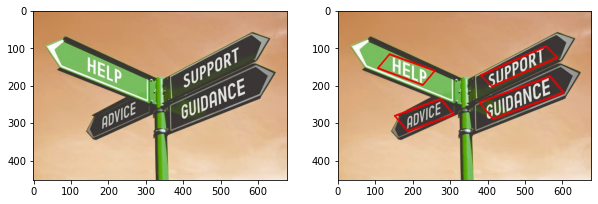

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(r"D:\Notsaved\z0090634\Downloads\Signpost vs Signboard vs Billboard.jpg"))
plt.subplot(1,2,2)
plt.imshow(cv2.imread("img_boxed.jpg"))